<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Decide which algorithm and version of the data we are going to use for model training

Additionally, choose:
* if we'll skip scaling the data
* if we'll use full categories instead of dummies
* what fraction of the data we'll use for testing (0.1)
* if the data split will be randomised (it won't!)

In [105]:
ALGORITHM = 'Linear Regression (Ridge)'
#ALGORITHM = 'KNN'
#ALGORITHM = 'Decision Tree'
#ALGORITHM = 'Random Forest'
#ALGORITHM = 'XG Boost (tree)'
#ALGORITHM = 'CatBoost'
#ALGORITHM = 'Light Gradient Boosting'

ALGORITHM_DETAIL = 'random search'
#DATA_DETAIL = ['explore param']
#DATA_DETAIL = ['no scale','no dummies']
DATA_DETAIL = ['no dummies'] if 'catboost' in ALGORITHM.lower() else []
#VERSION = '06'
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

print(f'ALGORITHM: {ALGORITHM}')
print(f'ALGORITHM_DETAIL: {ALGORITHM_DETAIL}')
print(f'DATA VERSION: {VERSION}')
print(f'DATA_DETAIL: {DATA_DETAIL}')

model_uses_feature_importances = 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower()
create_python_script = True

ALGORITHM: Linear Regression (Ridge)
ALGORITHM_DETAIL: random search
DATA VERSION: 06
DATA_DETAIL: []


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: loading all dependencies



In [106]:
%pip install tabulate

if ALGORITHM == 'CatBoost':
    %pip install catboost

if ALGORITHM == 'Light Gradient Boosting':
    %pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [107]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt
import sys
import os

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

if "JPY_PARENT_PID" in os.environ:
    is_jupyter = True
else:
    is_jupyter = False

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None
OVERRIDE_VERBOSE = 1
#if quick_mode:OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

already_timed = False
no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL
#not_catboost = 'catboost' not in ALGORITHM.lower() or not no_dummies
using_catboost = 'catboost' in ALGORITHM.lower()

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_b__get_the_data_20221116 import set_csv_directory
    set_csv_directory('final_split')
else:
    cloud_run = True

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

from functions_0__common_20221116 import get_columns
from functions_b__get_the_data_20221116 import get_combined_dataset, get_source_dataframe
from functions_d1__prepare_cleanse_data_20221116 import tidy_dataset
from functions_d2__transform_enrich_data_20221116 import preprocess, feature_engineer
from functions_d3__prepare_store_data_20221116 import create_train_test_data
from functions_e__train_model_20221116 import get_chosen_model, make_modelling_pipeline, get_cv_params, fit_model_with_cross_validation, get_hyperparameters
from functions_f_evaluate_model_20221116 import get_best_estimator_average_time, get_results, update_results

print(env_vars)

{'notebook_environment': 'local', 'use_gpu': False, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


#### Include any overrides specific to the algorthm / python environment being used

In [108]:
running_locally = True
#running_locally = run_env == 'local'


if 'forest' in ALGORITHM.lower():
    #OVERRIDE_N_ITER = 5
    if use_gpu:
        OVERRIDE_JOBS = 8

if running_locally:
    if ALGORITHM.lower() in ['random forest','xg boost','xg boost (linear)','xg boost (tree)' ]:
        OVERRIDE_N_ITER = 3
    elif 'linear regression' in ALGORITHM.lower():
        OVERRIDE_N_ITER = 15
    else:
        OVERRIDE_N_ITER = 5


if 'forest' in ALGORITHM.lower() or True:
    OVERRIDE_VERBOSE = 2


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: defining the model pipeline



In [109]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def make_pipeline():
    return Pipeline([
        #('mms', MinMaxScaler()),
        ('std_scaler', StandardScaler()),
        ('model', get_chosen_model(ALGORITHM))
    ])


starter_pipe = make_pipeline()
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()), ('model', Ridge())])

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: get the data

In [110]:
columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)
LABEL = 'Price'

In [111]:
df, retrieval_type = get_source_dataframe(cloud_run, VERSION, folder_prefix='../../../', row_limit=None)
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))


    df = df[columns]

loaded data from ../../../data/final/df_listings_v06.csv


In [112]:
print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [113]:
df = preprocess(df, version=VERSION)
df = df.dropna()

In [114]:
df.head(5)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD


In [115]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True,
    no_dummies=no_dummies
)


if 'forest' in ALGORITHM.lower() or ALGORITHM.lower()=='light gradient boosting':
    y_train_orig = y_train
    y_train = y_train.ravel()

#print(X_train[0])
print(df.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)



(44127, 9)
(39714, 11) (4413, 11) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [116]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [117]:
starter_model = starter_pipe[-1]

In [118]:
X_train

array([[3.        , 3.        , 0.31661326, ..., 1.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.53093375, ..., 0.        , 1.        ,
        0.        ],
       [1.        , 1.        , 0.28550937, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [3.        , 1.        , 0.72181034, ..., 1.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.43589737, ..., 0.        , 1.        ,
        0.        ],
       [5.        , 3.        , 0.09716825, ..., 1.        , 0.        ,
        0.        ]])

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage:
* #### retrieve the hyperparameters for this model, and
* #### train the model



In [119]:
options_block = get_hyperparameters(ALGORITHM, use_gpu, prefix='../../../')

if 'explore param' in DATA_DETAIL:
    def automl_step(param_options, vary):
        for key2, value in param_options.items():
            #print(key2, value, vary)
            if key2 != vary and key2 != 'model__' + vary:
                param_options[key2] = [param_options[key2][0]]
        return param_options

    #options_block = automl_step(options_block, "model__epochs")
    explore_param = "alpha"
    options_block = automl_step(options_block, explore_param)

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS,
                                                                  override_verbose=OVERRIDE_VERBOSE
                                                                  )


if not using_catboost and len(param_options.keys()) > 2 and not already_timed and debug_mode:
    already_timed = True
    %timeit starter_pipe.fit(X_train, y_train)


print("cv:", cv, "n_jobs:", n_jobs, "refit:", refit, "n_iter:", n_iter, "verbose:", verbose)
#print('\n\nHyperparameters:')
#param_options if not using_catboost else options_block

cv: 3 n_jobs: 3 refit: True n_iter: 15 verbose: 2


In [120]:
def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


if not using_catboost:
    if ALGORITHM_DETAIL == 'grid search':
        crossval_runner = GridSearchCV(
            estimator=starter_pipe,
            param_grid=param_options,
            cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True, #n_iter=n_iter,
            #error_score='raise'
        )
    else:
        crossval_runner = RandomizedSearchCV(
            estimator=starter_pipe,
            param_distributions=param_options,
            cv=cv, n_jobs=n_jobs,  # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True,  #n_iter=n_iter,
            n_iter=n_iter,  # 1, #3
            #error_score='raise'
    )
    cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
        crossval_runner, X_train, y_train, fits=cv * n_iter)

else:
    from catboost import CatBoostRegressor, Pool

    #pool = Pool(df, cat_features=['tenure.tenureType'], label=df['Price'].values)
    pool_Xtrain = Pool(X_train, cat_features=[7], label=y_train)
    #pool_Xtest = Pool(X_train, cat_features=[7], label=y_train)
    pool_Xtest = Pool(X_test, cat_features=[7], label=y_test)
    import sys
    starter_model = model=CatBoostRegressor(iterations=3, depth=3, learning_rate=0.1, loss_function='RMSE', objective='RMSE')

    output = starter_model.randomized_search(options_block, # param_options,
                                    X=pool_Xtrain, # X_train,
                                    #y=y_train,
                                    #cat_features=[],
                                    cv=5,
                                    n_iter=100,
                                    partition_random_seed=101,
                                    calc_cv_statistics=True,
                                    #search_by_train_test_split=True,
                                    refit=True,
                                    shuffle=True,
                                    stratified=None,
                                    #train_size=0.8,
                                    #train_size=1,
                                    verbose=True,
                                    plot=True,
                                    log_cout=sys.stdout,
                                    log_cerr=sys.stderr)

    cat_params, cat_cv_results = output['params'], output['cv_results']
    crossval_runner = {"best_params_": cat_params, "cv_results_": cat_cv_results, "best_estimator_": None}
crossval_runner


Fitting 3 folds for each of 15 candidates, totalling 45 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/guava/PycharmProjects/capstone_str

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Total fit/CV time      : 8 seconds   (1670090615.9935563 ==> 1670090624.816574)

average fit/score time = 0.15s/0.01s
max fit/score time     = 0.78s/0.01s
refit time             = 0.14s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('model', Ridge())]),
                   n_iter=15, n_jobs=3,
                   param_distributions={'model__alpha': [1e-05, 0.0001, 0.001,
                                                         0.01, 0.1, 1, 10, 100,
                                                         1000],
                                        'model__copy_X': [True, False],
                                        'model__fit_intercept': [True, False],
                                        'model__max_iter': [10000, 1000, 100,
                                                            100000, 1000000],
                                        'model__positive': [False],
                                        'model__random_state': [101],
                                        'model__solver': ['auto', 'svd',
                                                          'cholesky', 'lsqr',
                                                          'sparse_cg', 'sag',
                                                          'saga', 'lbfgs'],
                                        'model__tol': [1e-05, 0.0001, 0.001,
                                                       0.01]},
                   return_train_score=True, scoring='r2', verbose=2)

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Get the results and print some graphs



In [121]:
if not using_catboost:
    best_estimator_pipe = crossval_runner.best_estimator_
    cv_results_df = pd.DataFrame(crossval_runner.cv_results_).sort_values('rank_test_score')

    print("Best Params\n",crossval_runner.best_params_, "\n---------------------")

    if debug_mode:
        print("CV results\n",crossval_runner.cv_results_, "\n---------------------")
        #print("Best Params\n",crossval_runner["best_params_"], "\n---------------------")

else:
    print(cat_params)
    print(cat_cv_results)

Best Params
 {'model__tol': 0.0001, 'model__solver': 'lsqr', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 1000000, 'model__fit_intercept': True, 'model__copy_X': False, 'model__alpha': 0.001} 
---------------------


In [122]:
key = f'{ALGORITHM} (v{VERSION})'.lower()

if not using_catboost:
    cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

    cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
    # if 'Neural' not in ALGORITHM:
    #     cv_columns.insert(2, 'mean_train_score')
    cv_results_df_full_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)

    cv_results_df_sorted = cv_results_df_full_sorted[cv_results_df_full_sorted['mean_test_score'] > -2]
    if len(cv_results_df_sorted) != len(cv_results_df_full_sorted):
        print(-len(cv_results_df_sorted) + len(cv_results_df_full_sorted), "fits were total failures")
        total_fits = len(cv_results_df_sorted)

if not using_catboost:
    display(cv_results_df_sorted)

    orig_debug_mode, orig_display_df_cols = debug_mode, pd.get_option('display.max_columns')
    debug_mode = True
    pd.set_option('display.max_columns', None)
    if debug_mode:
        debug_cols = ['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
        debug_cols.extend([c for c in cv_results_df.columns if 'param' in c and c != 'params'])

    cv_results_df_summary = cv_results_df[debug_cols].head(7)
    cv_results_df_summary.set_index('rank_test_score', inplace=True)

    display(cv_results_df_summary)

8 fits were total failures


,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,0.0001/lsqr/101/False/1000000/True/False/0.001,1,0.444666,0.039158,0.007053,"{'model__tol': 0.0001, 'model__solver': 'lsqr'..."
1,1e-05/sag/101/False/10000/True/True/10,2,0.444664,0.780991,0.003418,"{'model__tol': 1e-05, 'model__solver': 'sag', ..."
2,1e-05/cholesky/101/False/10000/True/True/1,3,0.444663,0.041428,0.005614,"{'model__tol': 1e-05, 'model__solver': 'choles..."
3,0.01/cholesky/101/False/100000/True/False/1,3,0.444663,0.035421,0.006644,"{'model__tol': 0.01, 'model__solver': 'cholesk..."
4,1e-05/svd/101/False/1000/True/False/0.01,5,0.444663,0.036152,0.009816,"{'model__tol': 1e-05, 'model__solver': 'svd', ..."
5,0.0001/auto/101/False/10000/True/False/0.0001,6,0.444663,0.023113,0.003711,"{'model__tol': 0.0001, 'model__solver': 'auto'..."
6,0.001/saga/101/False/1000000/True/True/1,7,0.444661,0.200031,0.003455,"{'model__tol': 0.001, 'model__solver': 'saga',..."


,mean_test_score,mean_fit_time,mean_score_time,param_model__tol,param_model__solver,param_model__random_state,param_model__positive,param_model__max_iter,param_model__fit_intercept,param_model__copy_X,param_model__alpha,params2
rank_test_score,,,,,,,,,,,,
1,0.444666,0.039158,0.007053,0.0001,lsqr,101,False,1000000,True,False,0.001,0.0001/lsqr/101/False/1000000/True/False/0.001
2,0.444664,0.780991,0.003418,0.00001,sag,101,False,10000,True,True,10,1e-05/sag/101/False/10000/True/True/10
3,0.444663,0.041428,0.005614,0.00001,cholesky,101,False,10000,True,True,1,1e-05/cholesky/101/False/10000/True/True/1
3,0.444663,0.035421,0.006644,0.01,cholesky,101,False,100000,True,False,1,0.01/cholesky/101/False/100000/True/False/1
5,0.444663,0.036152,0.009816,0.00001,svd,101,False,1000,True,False,0.01,1e-05/svd/101/False/1000/True/False/0.01
6,0.444663,0.023113,0.003711,0.0001,auto,101,False,10000,True,False,0.0001,0.0001/auto/101/False/10000/True/False/0.0001
7,0.444661,0.200031,0.003455,0.001,saga,101,False,1000000,True,True,1,0.001/saga/101/False/1000000/True/True/1


<code style="background:blue;color:blue">**************</code>

#### Mini Stage: Make predictions



In [123]:
if not using_catboost:
    y_pred = best_estimator_pipe.predict(X_test)
else:
    y_pred = starter_model.predict(pool_Xtest)

In [124]:
y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Linear Regression (Ridge)----------
R square Accuracy 0.45688859223529354
Mean Absolute Error Accuracy 63603.05970548281
Mean Squared Error Accuracy 6135206763.744385
Root Mean Squared Error 78327.56069063037


In [125]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)

combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'],
                                                                                                     ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']] = combined[
    ['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
122265818,160000,584041,424041.613683,265.026009,72.604692,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
85667184,122000,360047,238047.004165,195.120495,66.115535,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD
109722224,108000,315095,207095.210019,191.754824,65.724646,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
83639617,190000,433679,243679.988620,128.252626,56.188894,190000,2,2,0.162816,51.491264,0.064660,0.008456,0.169080,LEASEHOLD
119684411,200000,431903,231903.760279,115.951880,53.693388,200000,2,1,0.511626,51.518081,-0.029340,0.018361,0.075080,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124085846,375000,374917,82.961725,0.022123,0.022128,375000,2,2,0.428537,51.357450,-0.199680,0.142270,0.095260,LEASEHOLD
110798696,400000,399919,80.240610,0.020060,0.020064,400000,2,2,0.339555,51.399354,-0.259059,0.100366,0.154639,LEASEHOLD
125723672,430000,429935,64.437254,0.014985,0.014988,430000,2,1,0.326995,51.536369,-0.248697,0.036649,0.144277,LEASEHOLD
119335547,575000,575073,73.960383,0.012863,0.012861,575000,4,2,0.298893,51.435710,0.050570,0.064010,0.154990,FREEHOLD


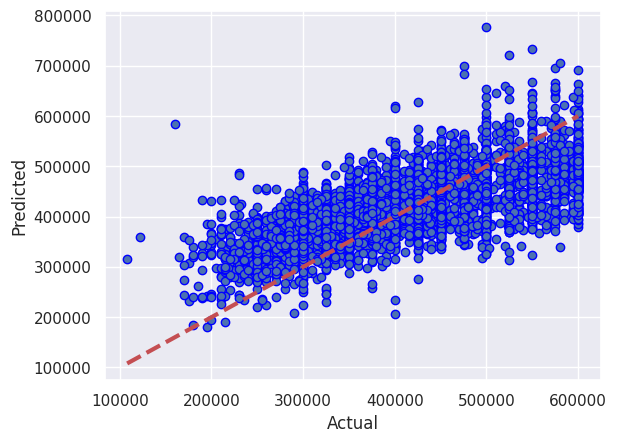

In [126]:
best_model_fig, best_model_ax = plt.subplots()
best_model_ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
best_model_ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
best_model_ax.set_ylabel('Predicted')
best_model_ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')

plt.show()

In [127]:
if not using_catboost:
    def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
        graph_model = model
        graph_model.set_params(**graph_params)
        graph_model.fit(X_train, y_train)
        y_pred_graph = model.predict(X_test)

        return model, y_pred_graph


    best_model_count = 10 if not quick_mode else 2
    best_model_count = 3 if not quick_mode else 1
    best_models = {}
    best_model_predictions = {}
    best_model_scores = {}

    showable_increment = total_fits // (4 if not quick_mode else 2)
    if showable_increment==0:showable_increment=1
    for i in range(0, total_fits, showable_increment):
        if debug_mode: print(f'{i} ==> {i}')

        if i == 0:
            fitted_graph_model = crossval_runner.best_estimator_
            y_pred_graph = y_pred
        else:
            graph_pipe_params = cv_results_df_sorted['params'][i]
            print(graph_pipe_params)
            # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

            graph_params = {}
            for key2, value in graph_pipe_params.items():
                graph_params[key2.replace('model__', '')] = value

            fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                            y_train, X_test)

        best_models[i] = fitted_graph_model[-1].get_params()
        best_model_predictions[i] = y_pred_graph
        best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

    if debug_mode: print(f'{-1} ==> {-1}')
    graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
    print(graph_pipe_params)
    graph_params = {}
    for key2, value in graph_pipe_params.items():
        graph_params[key2.replace('model__', '')] = value
    fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                    y_train, X_test)
    best_models[-1] = fitted_graph_model[-1].get_params()
    best_model_predictions[-1] = y_pred_graph
    best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


0 ==> 0
1 ==> 1
{'model__tol': 1e-05, 'model__solver': 'sag', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 10000, 'model__fit_intercept': True, 'model__copy_X': True, 'model__alpha': 10}
2 ==> 2
{'model__tol': 1e-05, 'model__solver': 'cholesky', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 10000, 'model__fit_intercept': True, 'model__copy_X': True, 'model__alpha': 1}
3 ==> 3
{'model__tol': 0.01, 'model__solver': 'cholesky', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 100000, 'model__fit_intercept': True, 'model__copy_X': False, 'model__alpha': 1}
4 ==> 4
{'model__tol': 1e-05, 'model__solver': 'svd', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 1000, 'model__fit_intercept': True, 'model__copy_X': False, 'model__alpha': 0.01}
5 ==> 5
{'model__tol': 0.0001, 'model__solver': 'auto', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 10000, 'model__fit_inter

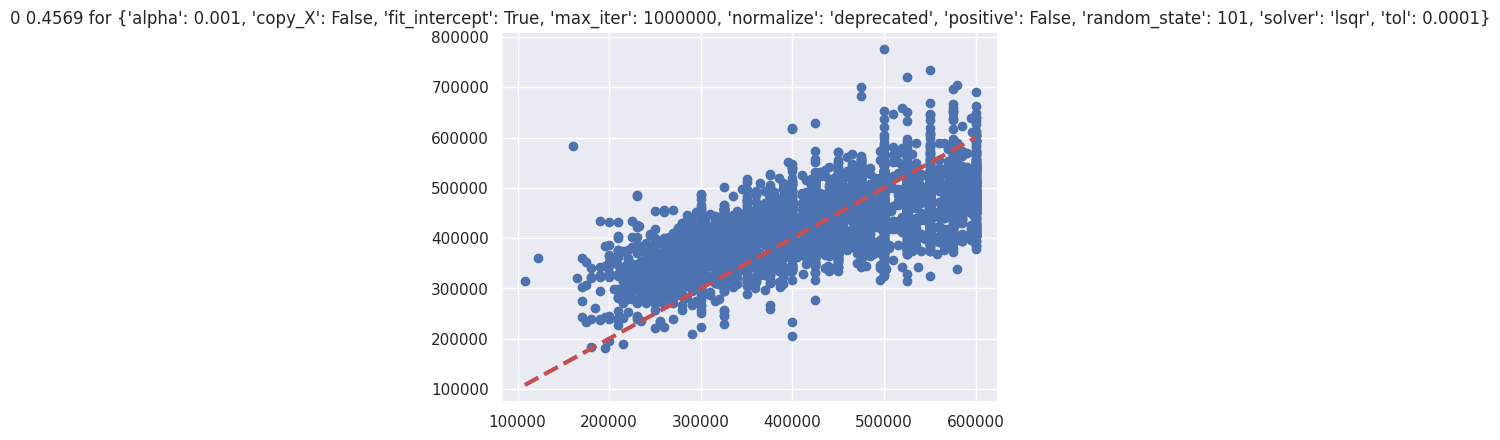

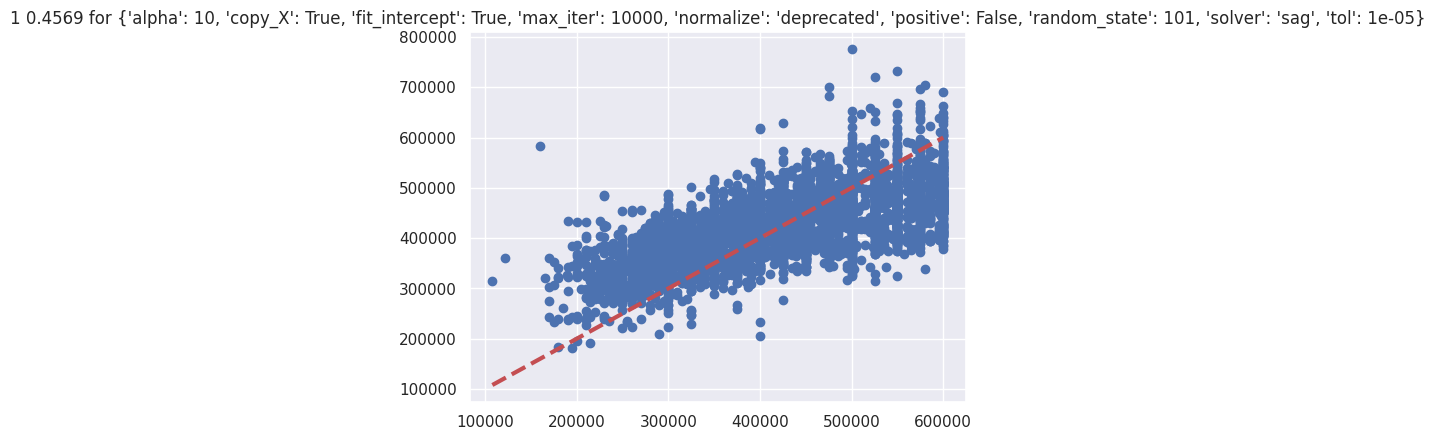

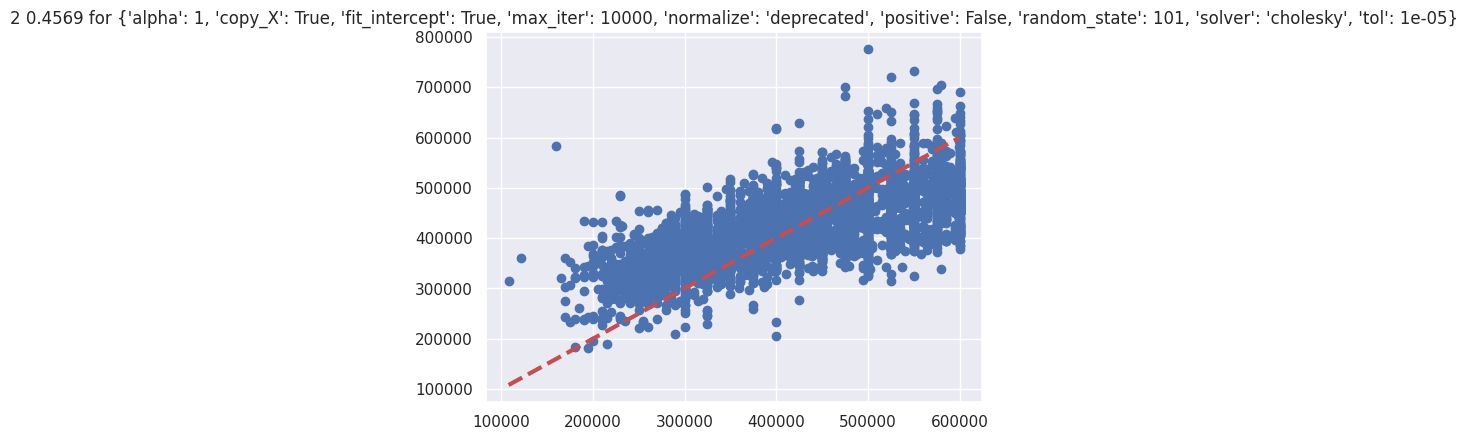

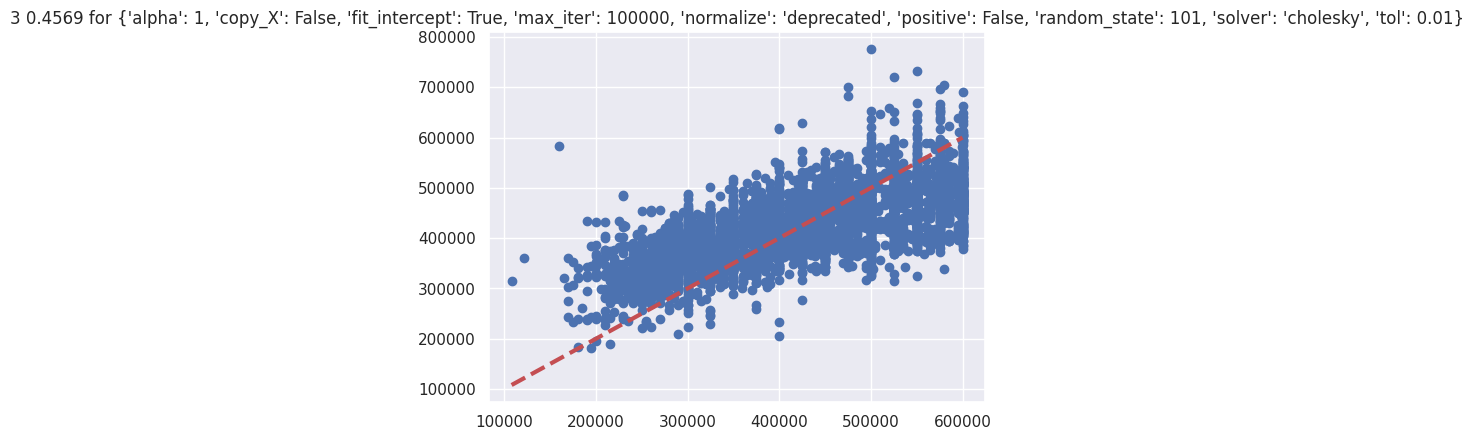

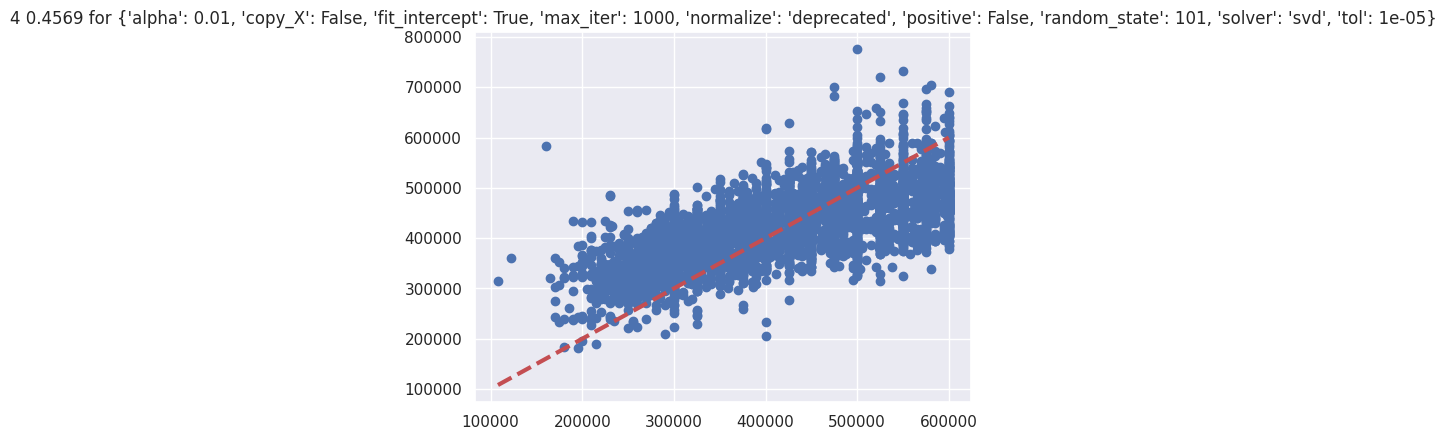

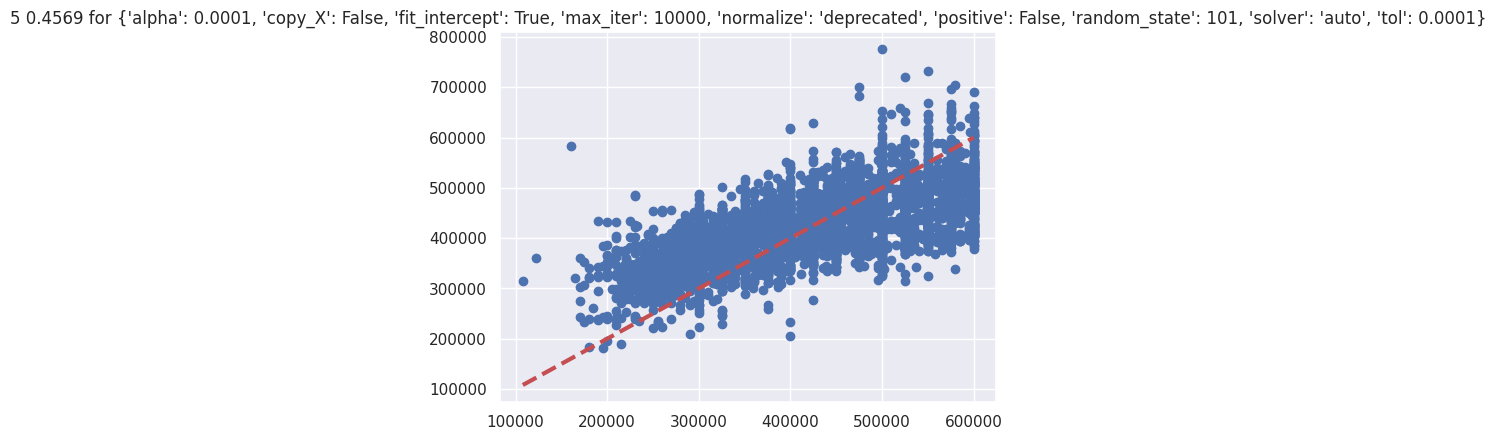

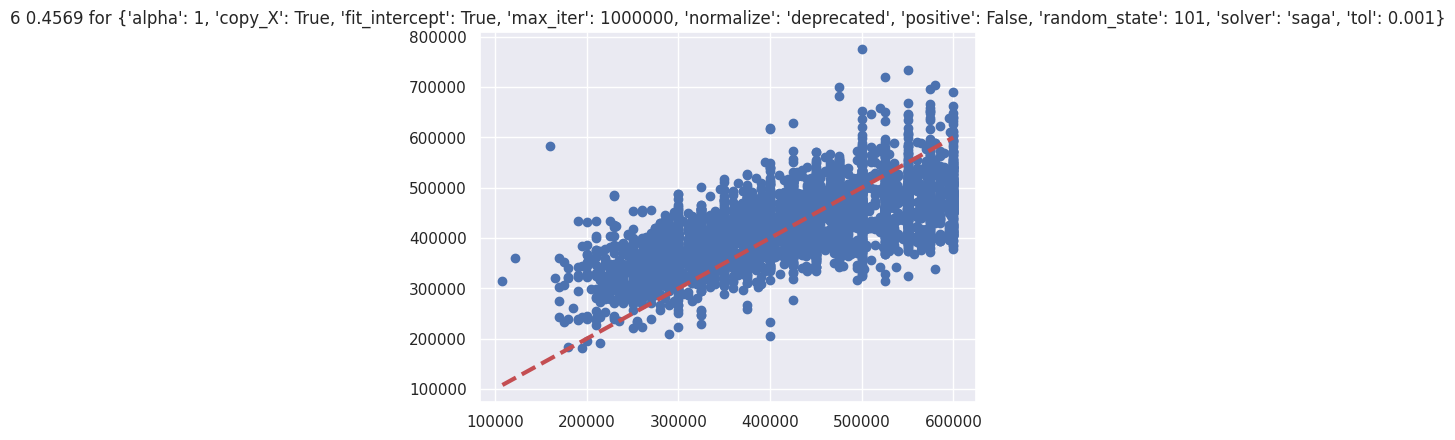

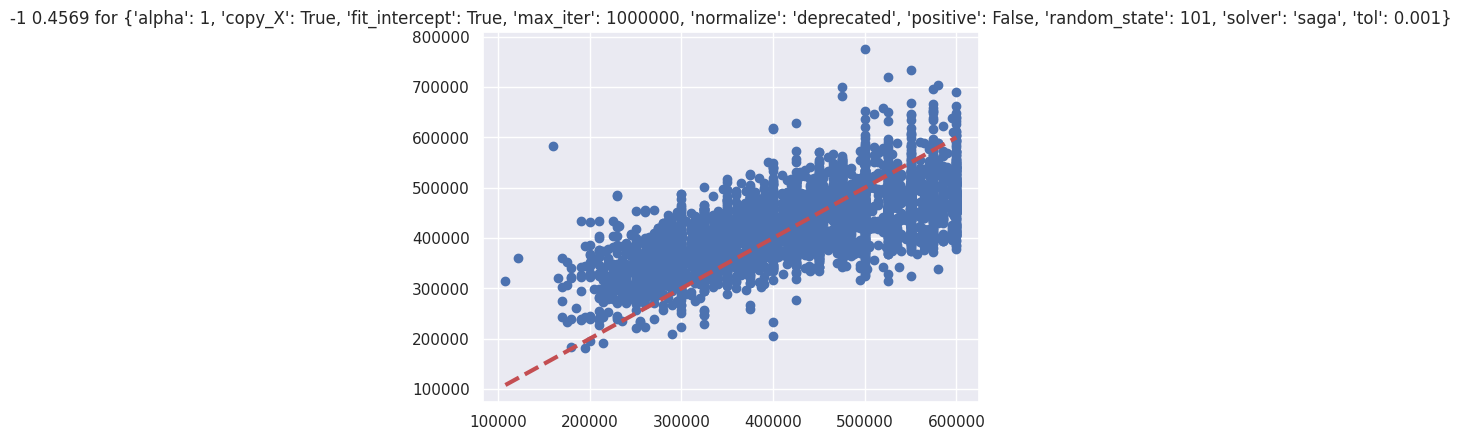

In [128]:
if not using_catboost:
    for i in best_model_scores.keys():
        if i >= 0:
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
            plt.scatter(y_test, best_model_predictions[i])
            # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            if len(best_models[i].keys()) < 30:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            else:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
            plt.show()

    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    plt.scatter(y_test, best_model_predictions[-1])
    # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
    if len(best_models[i].keys()) < 30:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for " + str(best_models[-1]))
    else:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i))

    plt.show()

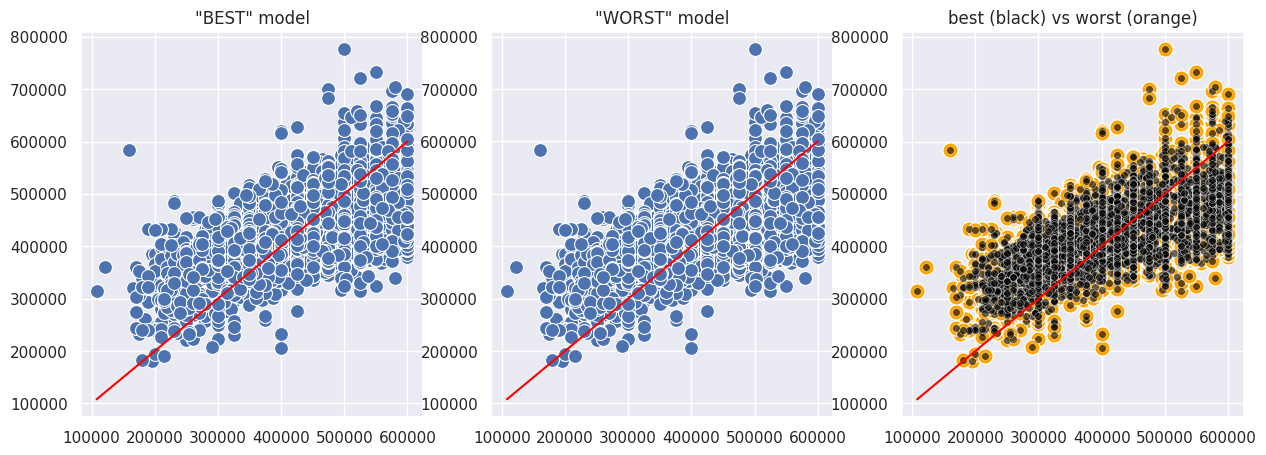

In [129]:
if not using_catboost:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    worst_and_best_model_fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')


    best_model_fig.tight_layout()
    plt.show()

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Evaluate the model



In [130]:
# <catboost.core.CatBoostRegressor object at 0x7fb167387490>
# {'depth': 6}
# defaultdict(<class 'list'>, {'iterations': [0, 1, 2],
# 'test-RMSE-mean': [396884.9605444017, 359548.6632536235, 326027.84885587444],
# 'test-RMSE-std': [308.9495320039113, 260.0967808594464, 219.65856329246023],
# 'train-RMSE-mean': [396884.77936957515, 359542.3612912551, 326018.9404460669],
# 'train-RMSE-std': [91.44140078375503, 86.77961380623475, 69.4038638987425]})

cv_best_model_fit_time = cv_best_model_fit_time if not using_catboost else 999

DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""

method =  f"{ALGORITHM_DETAIL}{DD2}"

new_results = {
    '_score': R2,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    '_params': crossval_runner.best_params_ if not using_catboost else cat_params,
    '_method':method,
    'run_env': run_env
}

if run_env not in ['colab']:
    old_results_json = get_results()
    try:
        old_best_score = old_results_json[key]['best score']
    except:
        print(f"haven't scored this model yet: {ALGORITHM}")
        old_best_score = -999
    this_model_is_best = update_results(old_results_json, new_results, key)

print(key)
new_results

linear regression (ridge) (v06)


{'_score': 0.45688859223529354,
 'R square Accuracy': 0.45688859223529354,
 'Mean Absolute Error Accuracy': 63603.05970548281,
 'Mean Squared Error Accuracy': 6135206763.744385,
 'Root Mean Squared Error': 78327.56069063037,
 '_train time': 0.1431288719177246,
 'random_state': 101,
 'date': '2022-12-03 18:03:58.418537',
 '_params': {'model__tol': 0.0001,
  'model__solver': 'lsqr',
  'model__random_state': 101,
  'model__positive': False,
  'model__max_iter': 1000000,
  'model__fit_intercept': True,
  'model__copy_X': False,
  'model__alpha': 0.001},
 '_method': 'random search',
 'run_env': 'local',
 'first run': '2022-11-15 21:02:22.079702',
 'best is shared': False,
 'silver score': 0.456900104350899,
 'silver time': 0.24377083778381348,
 'silver params': {'model__alpha': 0.001,
  'model__copy_X': False,
  'model__fit_intercept': True,
  'model__max_iter': 10000,
  'model__positive': False,
  'model__random_state': 101,
  'model__solver': 'sag',
  'model__tol': 0.001},
 'silver method

In [131]:
crossval_runner.best_estimator_  if not using_catboost else ''

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 Ridge(alpha=0.001, copy_X=False, max_iter=1000000,
                       random_state=101, solver='lsqr', tol=0.0001))])

In [132]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        if not using_catboost:
            pickle.dump(crossval_runner.best_estimator_, f)
        else:
            pickle.dump(starter_model, f)
        new_model_decision = f"pickled new version of model\n{old_results_json[key]['_score']} is new best score (it's better than {old_best_score})"
        #print(results_json[key]['_score'], 'is an improvement on', results_json[key]['second best score'])
else:
    new_model_decision = f"not updated saved model, the previous run was better\n{old_results_json[key]['_score']} is worse than or equal to '{old_best_score}"

print(new_model_decision)

not updated saved model, the previous run was better
0.45688859223529354 is worse than or equal to '0.456900104350899


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Investigate the feature importances (if applicable)


In [133]:
if model_uses_feature_importances:
    feature_importances = crossval_runner.best_estimator_[-1].feature_importances_ if not using_catboost else starter_model.get_feature_importance()
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

    indices = np.argsort(feature_importances)[::-1]

    print('Feature Ranking:')

    feature_importances_output = ""
    for f in range(X_train.shape[1]):
        #print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]), df_features.columns[indices[f] + 1])
        feature_importances_output += ('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]))
        feature_importances_output += '\t\t'
        feature_importances_output += (df_features.columns[indices[f] + 1])
        feature_importances_output += '\n'
    print(feature_importances_output)
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

Linear Regression (Ridge) does not have feature_importances, skipping


In [134]:
if model_uses_feature_importances:
    indices = np.argsort(feature_importances)

    feature_importance_fig, best_model_ax = plt.subplots(figsize=(20, 20))
    best_model_ax.barh(range(len(feature_importances)), feature_importances[indices])
    best_model_ax.set_yticks(range(len(feature_importances)))
    _ = best_model_ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

Linear Regression (Ridge) does not have feature_importances, skipping


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Write the final report for this algorithm and dataset version

In [135]:
from bs4 import BeautifulSoup


def include_in_html_report(type, section_header=None, section_figure=None, section_content=None, section_content_list=None):

    # writePath_html = r'model_results/%s (html).html' % key
    # writePath_md = r'model_results/%s (md).md' % key
    results_root = '../../F_evaluate_model'
    writePath_html = f'{results_root}/html/{key}.html'.replace(" ", "_").replace("(", "_").replace(")", "_")
    writePath_md = f'{results_root}/markdown/{key}.md'

#isinstance(ini_list2, list)
    if not section_content_list:
        section_content_list = [section_content]

    if type == 'header':
        w = 'w' if section_figure <= 1 else 'a'
        with open(writePath_html, w) as f1:
            headers = f'<h{section_figure}>{section_content}</h{section_figure}>'
            f1.write(headers)
        with open(writePath_md, w) as f2:
            headers = f'{"#" * int(section_figure)} {section_content }\n'
            f2.write(headers)
    else:
        if section_header:
            with open(writePath_html, 'a') as f1:
                f1.write(f'<h3>{section_header}</h3>')
            with open(writePath_md, 'a') as f2:
                f2.write(f'### {section_header}\n')

        if type=='dataframe':
            with open(writePath_html, 'a') as f1:
                dfAsString = section_content.to_html()
                f1.write(dfAsString)
            with open(writePath_md, 'a') as f2:
                dfAsString = section_content.to_markdown()
                f2.write(dfAsString + '\n')
        elif type=='graph':
            filename = key + "_" + section_content
            #section_figure.savefig(f'model_results/artifacts/{filename.replace(" ", "_")}')
            section_figure.savefig(f'{results_root}/artifacts/{filename.replace(" ", "_").replace("(", "_").replace(")", "_")}')

            with open(writePath_html, 'a') as f1:
                dfAsString = f'<img src="../artifacts/{filename.replace(" ","_").replace("(", "_").replace(")", "_")}"/>'
                f1.write(dfAsString)

            with open(writePath_md, 'a') as f2:
                #dfAsString = f'(./model_results/artifacts/{filename}) \n'
                #dfAsString = f'![detail](./artifacts/{filename.replace(" ","_")})'
                dfAsString = f'![detail](../artifacts/{filename.replace(" ","_").replace("(", "_").replace(")", "_")})'
                f2.write(dfAsString)
                f2.write('\n')
        elif type=='json':

            # html_content_parsed = [[cell.text for cell in row("td")]
            #              for row in BeautifulSoup(content,features="html.parser")("tr")]
            #
            # html_content_dictionary = {element[0]:element[1:] for element in html_content_parsed}

            #xxxprint(json.dumps(html_content_dictionary, indent=4))



            with open(writePath_html, 'a') as f1:
                #f.write(json.dumps(html_content_dictionary, indent=4))
                soup = BeautifulSoup(section_content, "html.parser")
                f1.write(str(soup.prettify()))
            with open(writePath_md, 'a') as f2:
                #f.write(json.dumps(html_content_dictionary, indent=4))
                soup = BeautifulSoup(section_content, "html.parser")
                #f2.write(str(soup.prettify()))


                # html_content_dictionary = {element[0]:element[1:] for element in html_content_parsed}
                # f2.write(json.dumps(html_content_dictionary, indent=4))

                import ast
                loads = ast.literal_eval(section_content)
                #df = pd.DataFrame.from_dict(loads)
                #df.drop(['dont'], axis=1, inplace=True)
                #print(df.to_markdown(index=False,tablefmt='fancy_grid'))
                for each in loads:
                    f2.write(each + " = " + str(loads[each]) + "\n\n")

        elif type=='dict':

            for section_content in section_content_list:
                if isinstance(section_content, str):
                    import ast
                    section_content = ast.literal_eval(section_content)

                with open(writePath_html, 'a') as f1:
                    soup = BeautifulSoup(str(section_content), "html.parser")
                    f1.write(str(soup.prettify()))
                with open(writePath_md, 'a') as f2:
                    for each in section_content:
                        f2.write(each + " = " + str(section_content[each]) + "\n\n")

        elif type=='text':
            with open(writePath_html, 'a') as f1:
                for each_line in section_content_list:
                    f1.write(each_line + '<br>')
            with open(writePath_md, 'a') as f2:
                for each_line in section_content_list:
                    f2.write(each_line + '\n\n')

        with open(writePath_html, 'a') as f1:
            f1.write('<hr>')


include_in_html_report("header", section_content=f"Results from {ALGORITHM}", section_figure=1)

include_in_html_report(type="text", section_header=f"Dataset Version: {VERSION}", section_content=f"Date run:{datetime.now()}")

include_in_html_report("header", section_content=f"Results", section_figure=2)

include_in_html_report(type="text", section_header="Summary", section_content=new_model_decision)

#include_in_html_report(type="dataframe",text_single="Tuned Models ranked by performance", content=cv_results_df_sorted)

if not using_catboost:
    include_in_html_report(type='dataframe', section_header='Tuned Models ranked by performance, with parameter details', section_content=cv_results_df_summary)

    include_in_html_report(type='graph', section_header='Best and worst models obtained by tuning', section_figure=worst_and_best_model_fig, section_content="best_and_worst.png")

    include_in_html_report(type='graph', section_header='Best Model: Comparing model predictions to actual property values', section_figure=best_model_fig, section_content='best_model_correlation.png')
else: #if using_catboost:
    include_in_html_report(type="text", section_header="Model Specific Notes", section_content_list=["can't display hyperparameter comparison for catboost","can't display model performance graphs for catboost","can't display model performance graphs for catboost"])


if model_uses_feature_importances:
    include_in_html_report("header", section_content=f"Feature Importances", section_figure=2)
    include_in_html_report(type="text", section_header="Feature Importances", section_content=feature_importances_output)
    include_in_html_report(type="graph", section_header=f"Feature Importances ({ALGORITHM})", section_figure=feature_importance_fig, section_content='best_model_feature_importances.png')


include_in_html_report("header", section_content=f"Comparison with other models", section_figure=2)


dff = pd.read_json('../../../results/results.json')

version = VERSION


all_models_df = dff[dff.columns].T.sort_values("best score", ascending=False)
version_models_df = dff[[c for c in dff.columns if version in c]].T.sort_values("best score", ascending=False)

version_models_summary = version_models_df[['best score', 'best time', 'Mean Absolute Error Accuracy', 'Mean Squared Error Accuracy', 'R square Accuracy', 'Root Mean Squared Error', 'best run date', 'best method']]
all_models_summary = all_models_df[['best score', 'best time', 'Mean Absolute Error Accuracy', 'Mean Squared Error Accuracy', 'R square Accuracy', 'Root Mean Squared Error', 'best run date', 'best method']]

include_in_html_report(type="dataframe", section_header=f"Comparison with version {VERSION} performances", section_content=version_models_summary)
include_in_html_report(type="dataframe", section_header="Comparison with all model performances", section_content=all_models_summary)


include_in_html_report("header", section_content=f"Appendix", section_figure=2)

include_in_html_report(type="dataframe", section_header="Data Sample", section_content=df.head(5))

include_in_html_report(type="json", section_header="Hyperparameter options for Randomized Grid Search", section_content=f"{param_options if not using_catboost else options_block}")


include_in_html_report(type="dict", section_header="Environment Variables", section_content=env_vars)


def print_and_report(text_single, title):
    include_in_html_report("text", section_content=title)
    for each in text_single:
        print(each)
        include_in_html_report("text", section_header="", section_content=each)

# if not catboost:
#     print_and_report([
#         'Best Index:' + str(crossval_runner.best_index_) + '<br>',
#         'Best Score:' + str(crossval_runner.best_score_) + '<br>',
#         'Best Params: ' + str(crossval_runner.best_params_) + '<br>'
#     ], "Best Model Details")



In [136]:
print('Nearly finished...')

Nearly finished...


In [137]:
# !jupyter nbconvert --to script mycode.ipynb
# with open('it10_all_models_20221203.ipynb', 'r') as f:
#     lines = f.readlines()
# with open('mycode.py', 'w') as f:
#     for line in lines:
#         if 'nbconvert --to script' in line:
#             break
#         else:
#             f.write(line)

if create_python_script and is_jupyter:
    !jupyter nbconvert --to script 'it10_all_models_20221203.ipynb'

#!jupyter nbconvert --to script 'it10_all_models_20221203.ipynb' &&  \
#!mv ./folder/notebooks/*.py ./folder/python_scripts && \

[NbConvertApp] Converting notebook it10_all_models_20221203.ipynb to script
[NbConvertApp] Writing 35609 bytes to it10_all_models_20221203.py


In [138]:
print('Finished!')

Finished!
